In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt

import os

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
# HARDCODED FOR LLAVA
num_heads = 40
num_layers = 40

base_dir = 'features_attack'
n_options_all = [2, 3, 4]
val_ratio = .2

In [12]:
def get_performance_dict(X, y, num_layers, num_heads):
    head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            X_probe = X[:, l, h, :]
            y_probe = y[:]
            _, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
            head_perf_dict[f'l{l}_h{h}'] = val_acc
    return head_perf_dict

In [13]:
def train_option_probe(n_options):
    feature_dir_all = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f'noption_{n_options}' in f]
    true_dir = [f for f in feature_dir_all if 'original' in f]
    bias_dir = [f for f in feature_dir_all if 'original' not in f]

    X_true = np.load(f"{true_dir[0]}/head_wise.npy")
    X_true = rearrange(X_true, 'b l (h d) -> b l h d', h = num_heads)
    y_true = [1 for i in range(X_true.shape[0])]

    head_perf_all = []
    for dir in bias_dir:
        X_bias = np.load(f"{dir}/head_wise.npy")
        X_bias = rearrange(X_bias, 'b l (h d) -> b l h d', h = num_heads)
        y_bias = [0 for i in range(X_bias.shape[0])]
        X = np.vstack((X_true, X_bias))
        y = np.hstack((y_true, y_bias))
        head_perf_dict = get_performance_dict(X, y, num_layers, num_heads)
        head_perf_all.append(head_perf_dict)
    head_perf_matrix = []
    for dict_ in head_perf_all:
        head_perf_matrix.append(np.array(list(head_perf_dict.values())).reshape(num_layers, num_heads))
    head_perf_matrix = np.dstack(head_perf_matrix)
    head_perf_matrix = np.mean(head_perf_matrix, axis=-1)
    return head_perf_matrix

In [14]:
head_perf_dict = {}
for n_options in n_options_all:
    head_perf_dict[n_options] = train_option_probe(n_options)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.17s/it]


/tmp/ipykernel_81215/2818572728.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map = plt.cm.get_cmap('viridis')


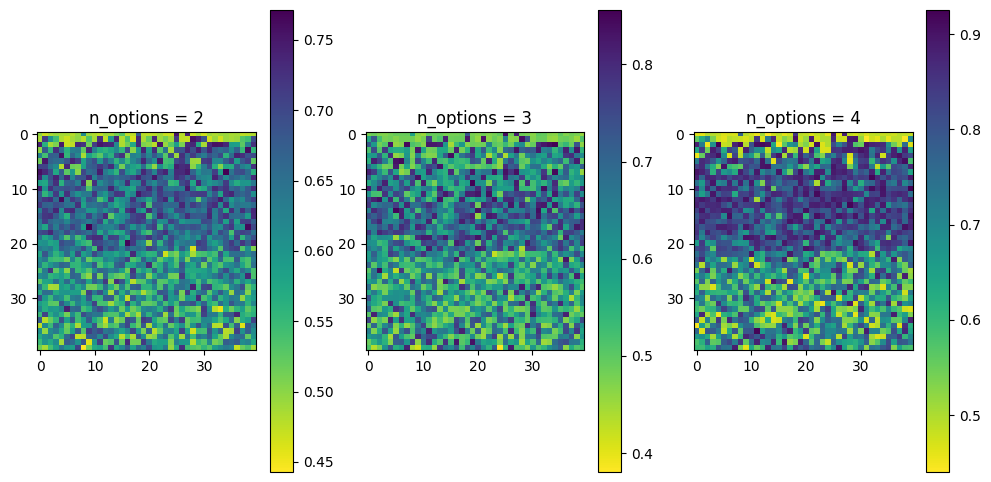

In [15]:
fig, axs = plt.subplots(1, len(head_perf_dict), figsize=(12,6))
orig_map = plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 
im_all = []
for i, key in enumerate(head_perf_dict):
    sorted = np.copy(head_perf_dict[key])
    sorted.sort(axis=1)
    im = axs[i].imshow(head_perf_dict[key], cmap = reversed_map)
    axs[i].set_title(f"n_options = {key}")
    im_all.append(im)
for i,im in enumerate(im_all):
    plt.colorbar(im,ax=axs[i])
plt.show()

In [30]:
def train_biased_probe(n_options):
    feature_dir_all = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f'noption_{n_options}' in f]
    true_dir = [f for f in feature_dir_all if 'original' in f]
    bias_dir = [f for f in feature_dir_all if 'original' not in f]

    X_true = np.load(f"{true_dir[0]}/head_wise.npy")
    X_true = rearrange(X_true, 'b l (h d) -> b l h d', h = num_heads)
    # y_true = [1 for i in range(X_true.shape[0])]
    y_true = np.load(f"{true_dir[0]}/labels.npy")
    y_true_binary = np.zeros(len(y_true))
    y_true_binary[np.argwhere(y_true[:,1]==1).flatten()] = 1
    # print(y_true)

    head_perf_all = []
    # for dir in bias_dir:
    bias_dir_random = np.random.choice(bias_dir, 2, replace=False)
    X_bias1 = np.load(f"{bias_dir_random[0]}/head_wise.npy")
    X_bias1 = rearrange(X_bias1, 'b l (h d) -> b l h d', h = num_heads)
    y_bias1 = [0 for i in range(X_bias1.shape[0])]

    X_bias2 = np.load(f"{bias_dir_random[1]}/head_wise.npy")
    X_bias2 = rearrange(X_bias2, 'b l (h d) -> b l h d', h = num_heads)
    y_bias2 = [1 for i in range(X_bias2.shape[0])]

    X_bias_all = np.vstack((X_bias1, X_bias2))
    y_bias_all = np.hstack((y_bias1, y_bias2))
    
    X_train, X_test, y_train, y_test = train_test_split(X_bias_all, y_bias_all, test_size=val_ratio)
    head_perf_matrix = np.zeros((num_layers, num_heads))
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            probe_train = X_train[:, l, h, :]
            probe_val = X_test[:, l, h, :]
            clf = LogisticRegression().fit(probe_train, y_train)
            y_pred = clf.predict(X_true[:, l, h, :])
            val_acc = accuracy_score(y_true_binary, y_pred)
            head_perf_matrix[l, h] = val_acc
    return head_perf_matrix

In [31]:
head_perf_dict = {}
for n_options in n_options_all[:1]:
    head_perf_dict[n_options] = train_biased_probe(n_options)

 32%|████████████████████████████████▊                                                                    | 13/40 [00:19<00:49,  1.83s/it]/opt/conda/envs/llava/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/llava/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

/tmp/ipykernel_81215/600955406.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map = plt.cm.get_cmap('viridis')


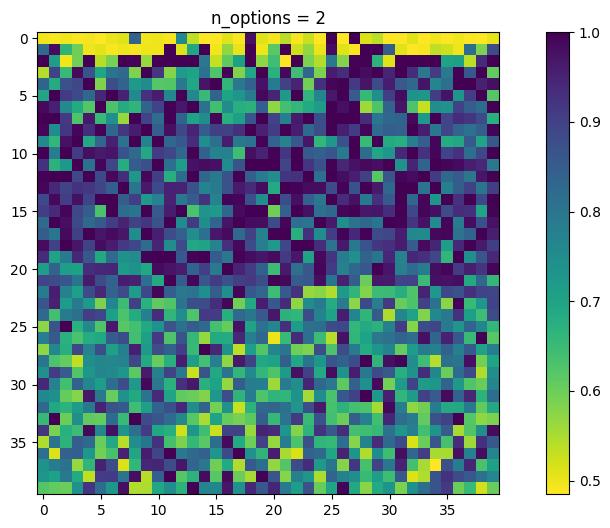

In [33]:
fig, axs = plt.subplots(1, len(head_perf_dict), figsize=(12,6))
orig_map = plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 
im_all = []
for i, key in enumerate(head_perf_dict):
    sorted = np.copy(head_perf_dict[key])
    sorted.sort(axis=1)
    im = axs.imshow(head_perf_dict[key], cmap = reversed_map)
    axs.set_title(f"n_options = {key}")
    im_all.append(im)
for i,im in enumerate(im_all):
    plt.colorbar(im,ax=axs)
plt.show()